In [3]:
import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time

import warnings
warnings.filterwarnings('ignore')


In [4]:
df1 = pd.read_csv("dataset/adult.csv")
df1.name = "adult-census-income"

**Define Models to be used for Synthetic Data Generation - CTGAN and TVAE**

In [5]:
from sdv.tabular import TVAE
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate

models_tvae = []
models_ctgan = []

for i in range(6):
    models_ctgan.append(CTGAN(batch_size=200, verbose=True, epochs=300))
    models_tvae.append(TVAE(batch_size=200, epochs=300))

In [6]:
dfs = [df1]

# To store generated synthetic data
synthetic_data_mapping = {}

metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence']
saved_models = {}

In [7]:
for df in dfs:
    print('\n' + '%'*40)
    print('\033[1m' + df.name + '\033[0m')
    print('%'*40 + '\n')
    df.info()
    synthetic_data_mapping[df.name] = []


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
adult-census-income
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usag

In [10]:
sec = 60
mins = 60 * 60
hour = 60 * 60 * 24

def get_formatted_time(interval):

    interval = int(interval)
    if interval < 60:
        return str(interval) + ' s'
    elif interval < mins:
        m = interval // 60
        s = interval % 60
        return str(m) + " min" + str(s) + " s"
    elif interval < hour:
        h = interval // (mins)
        m = interval % (mins)
        return str(h) + " hours" + str(m) + ' min'




In [12]:

def evaluate_model(model, df):
    
    print('Training in Progress - ' + model.__class__.__name__ + '-' + df.name + '\n')
    
    # Record training time
    start = time.time()
    model.fit(df)
    end = time.time()
    
    print( '\n' + model.__class__.__name__ + ' trained. \nTraining time: ' + get_formatted_time(end-start) + ' \n')
    syn_data = model.sample(len(df))
    syn_data.name = df.name + '-' + model.__class__.__name__
    synthetic_data_mapping[df.name].append(syn_data)    
    
    # Record evaluation time
    start = time.time()
    ee = evaluate(syn_data, df, metrics=metrics , aggregate=False)
    end = time.time()
    print("Synthetic Data Evaluation - " +  model.__class__.__name__ + '-' + df.name + '\n')
    display(ee)
    print('\nEvaluation time: ' + get_formatted_time(end-start) + ' \n')
    
    
    # Save the model
    saved_model_name = model.__class__.__name__ + '-' + df.name + '.pkl'
    model.save(saved_model_name)
    saved_models[saved_model_name] = model

In [13]:
k = 0;
for df in dfs:
    evaluate_model(models_ctgan[k], df)
    evaluate_model(models_tvae[k], df)
    k += 1

Training in Progress - CTGAN-adult-census-income

Epoch 1, Loss G:  1.7014,Loss D:  0.0021
Epoch 2, Loss G:  0.8490,Loss D:  0.0163
Epoch 3, Loss G:  0.4993,Loss D:  0.0054
Epoch 4, Loss G: -0.5209,Loss D: -0.1320
Epoch 5, Loss G: -1.1442,Loss D:  0.1211
Epoch 6, Loss G: -1.1573,Loss D:  0.0863
Epoch 7, Loss G: -1.6580,Loss D:  0.0856
Epoch 8, Loss G: -1.4810,Loss D: -0.2179
Epoch 9, Loss G: -1.4809,Loss D: -0.0731
Epoch 10, Loss G: -1.3767,Loss D: -0.0319
Epoch 11, Loss G: -1.1977,Loss D: -0.2953
Epoch 12, Loss G: -1.1362,Loss D: -0.0232
Epoch 13, Loss G: -1.1628,Loss D: -0.0637
Epoch 14, Loss G: -0.7315,Loss D: -0.1948
Epoch 15, Loss G: -0.8203,Loss D: -0.1323
Epoch 16, Loss G: -0.5468,Loss D: -0.4621
Epoch 17, Loss G: -0.4824,Loss D: -0.5000
Epoch 18, Loss G: -0.7140,Loss D:  0.1284
Epoch 19, Loss G: -0.2916,Loss D: -0.2448
Epoch 20, Loss G: -0.5529,Loss D:  0.3741
Epoch 21, Loss G: -0.8156,Loss D: -0.1335
Epoch 22, Loss G: -0.3961,Loss D:  0.1082
Epoch 23, Loss G: -0.3469,Loss D:  

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.982890,0.982890,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.844584,0.844584,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.910344,0.910344,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.889918,0.889918,0.0,1.0,MAXIMIZE,None



Evaluation time: 1seconds seconds 

Training in Progress - TVAE-adult-census-income


TVAE trained. 
Training time: 13min22s seconds 

Synthetic Data Evaluation - TVAE-adult-census-income



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.991773,0.991773,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.865596,0.865596,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.938300,0.938300,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.947363,0.947363,0.0,1.0,MAXIMIZE,None



Evaluation time: 1seconds seconds 



In [14]:
saved_models

{'CTGAN-adult-census-income.pkl': <sdv.tabular.ctgan.CTGAN at 0x1549700bd00>,
 'TVAE-adult-census-income.pkl': <sdv.tabular.ctgan.TVAE at 0x1549700ba00>}

In [15]:
synthetic_data_mapping[df1.name][0].head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,35,Private,97628,HS-grad,9,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,3253,0,45,Dominican-Republic,>50K
1,25,Private,47079,1st-4th,9,Separated,Other-service,Unmarried,White,Female,15,0,35,United-States,<=50K
2,42,Private,162786,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,7744,0,50,United-States,>50K
3,38,Private,198441,10th,6,Divorced,Machine-op-inspct,Not-in-family,White,Male,37,0,35,United-States,<=50K
4,62,Private,204605,11th,7,Married-civ-spouse,Transport-moving,Husband,Black,Male,0,0,36,United-States,<=50K


In [16]:
synthetic_data_mapping[df1.name][1].name

'adult-census-income-TVAE'

**Visualisation**

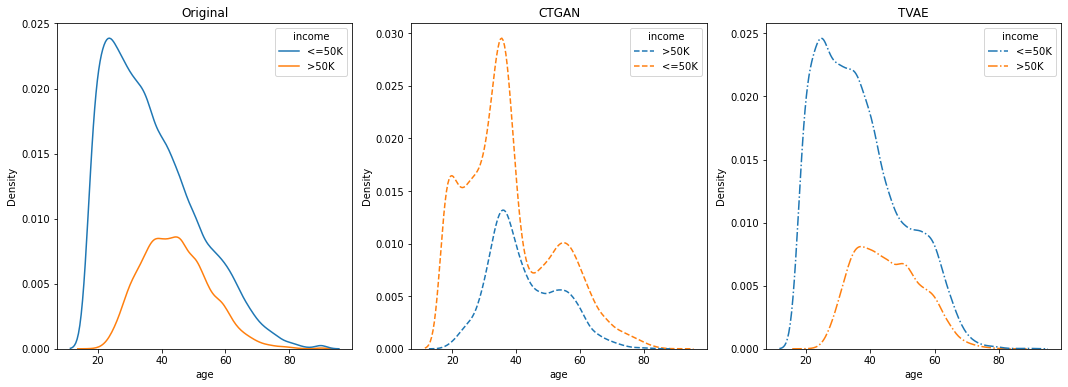

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
sns.kdeplot(data=df1,ax=ax0, x='age', hue='income').set(title="Original")
sns.kdeplot(data=synthetic_data_mapping[df1.name][0],ax=ax1, x='age', hue='income', label='ctgan', ls='--').set(title="CTGAN")
sns.kdeplot(data=synthetic_data_mapping[df1.name][1],ax=ax2, x='age', hue='income', label='tvae', ls='-.').set(title="TVAE")
plt.show()

In [18]:
obj_data = df1.select_dtypes(include=['object']).copy()
obj_data.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K


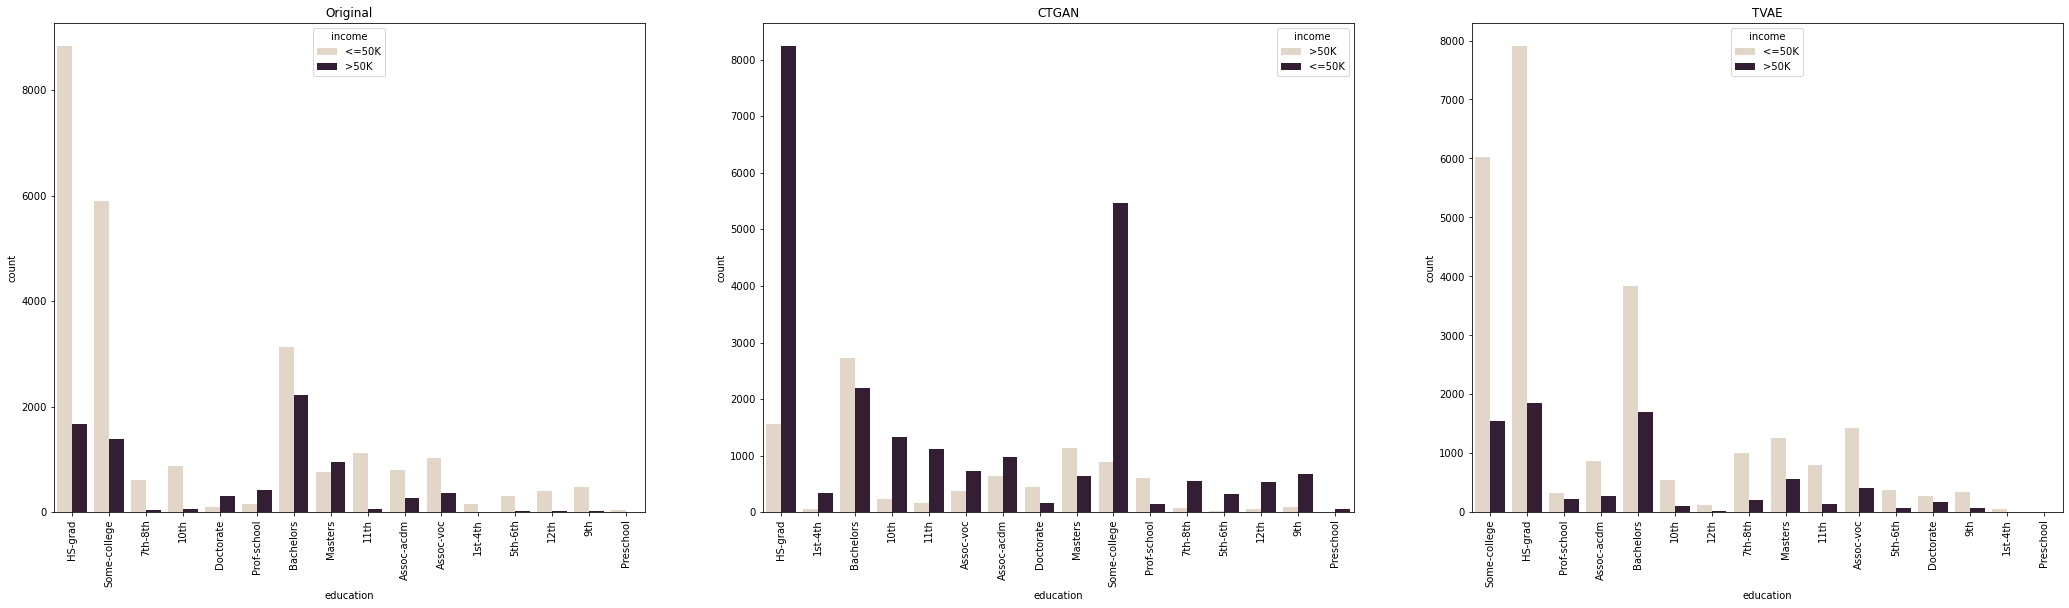

In [19]:
fig2, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(36, 9))
sns.countplot(x="education", hue='income', palette="ch:.25", data=df1, ax=ax0).set(title="Original")
sns.countplot(x="education", hue='income', palette="ch:.25", data=synthetic_data_mapping[df1.name][0], ax=ax1).set(title="CTGAN")
sns.countplot(x="education", hue='income', palette="ch:.25", data=synthetic_data_mapping[df1.name][1], ax=ax2).set(title="TVAE")
ax0.tick_params(axis='x', rotation=90)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)
plt.show()

In [20]:
synthetic_data_mapping[df1.name][1].groupby(['income']).size()

income
<=50K    25187
>50K      7374
dtype: int64

In [21]:
synthetic_data_mapping[df1.name][0].groupby(['income']).size()

income
<=50K    23452
>50K      9109
dtype: int64

In [22]:
df1.groupby('income').size()

income
<=50K    24720
>50K      7841
dtype: int64

In [23]:
# VBGMM
from sklearn.mixture import GaussianMixture

vbgmm = GaussianMixture(n_components=3, random_state=42)
col = df1['education.num'].values.reshape(-1,1)
vbg = vbgmm.fit(col)
vbg.means_.shape
vbg.means_

array([[ 9.45084037],
       [13.16587431],
       [ 5.65350733]])

In [24]:
import torch
x = torch.rand(4)
print(x)

tensor([0.5115, 0.8413, 0.2283, 0.0105])


**VAE for Adult Census Data**

In [ ]:
"""# select categorical data
obj_data = df1.select_dtypes(include=['object']).copy()
# List details of categories for each categorical data
for col in obj_data.columns:

    print('\n'+col+'\n')
    print(obj_data[col].value_counts())"""

In [ ]:
#df1['age'].value_counts().sort_values

In [ ]:
"""from sklearn.preprocessing import OrdinalEncoder

raw_data = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
raw_data.head()

raw_data.shape

# Count total null values in each column
data = raw_data.replace("?", np.nan)
data.isnull().sum(axis=0)

data.dtypes

# Remove Null values from columns
data = data.dropna()

# Rename columns as per python naming convention
data = data.rename(columns={"education.num": "education_num",
                            "marital.status": "marital_status", 
                           "capital.gain": "capital_gain", 
                           "capital.loss": "capital_loss", 
                           "hours.per.week": "hours_per_week",
                           "native.country": "native_country"})
data.head()

# Find correlation b/w variables
data.corr()

# select categorical data
obj_data = data.select_dtypes(include=['object']).copy()
obj_data.head()

# List details of categories for each categorical data
for col in obj_data.columns:

    print('\n'+col+'\n')
    print(obj_data[col].value_counts())
    
# Encoder
enc = OrdinalEncoder()

# Encode all categorical variables
def encode_categorical_cols(df):
    # List of categorical columns
    obj_cols = list(df.columns)

    for col in obj_cols:
        # Encode and make new column with _code appended
        df[col+'_code'] = enc.fit_transform(df[[col]])
    return df
        

enc_obj_data = encode_categorical_cols(obj_data)
enc_obj_data.head(10)"""

In [ ]:
"""
enc_obj_data.columns

data.shape

obj_data.shape

enc_obj_data.shape

merged_df = pd.concat([data, enc_obj_data], axis=1, join="inner", ignore_index=False)
merged_df.head()

merged_df.shape

merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
merged_df.shape

merged_df.dtypes

merged_df.head()"""

In [ ]:



"""import statsmodels.api as sm

m = sm.OLS.from_formula("income_code~ age + fnlwgt+ education_num + capital_gain + capital_loss + hours_per_week", merged_df)"""





